In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_add_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)
  
def add_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = residual_block
    
    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

model = residual_add_block(averaged_embedding_layer, should_pool = False)
model = residual_add_block(model, should_pool = True)
model = residual_add_block(model, should_pool = True)
model = residual_add_block(model, should_pool = True)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, epochs= 64, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/64
 20800/102124 [=====>........................] - ETA: 4:55 - loss: 0.1167 - acc: 0.9606

 59072/102124 [================>.............] - ETA: 2:24 - loss: 0.0841 - acc: 0.9711

 97376/102124 [===========================>..] - ETA: 15s - loss: 0.0746 - acc: 0.9741

102124/102124 [==============================] - 362s 4ms/step - loss: 0.0736 - acc: 0.9744 - val_loss: 0.0495 - val_acc: 0.9813
Epoch 2/64
 11968/102124 [==>...........................] - ETA: 4:49 - loss: 0.0570 - acc: 0.9793

 54880/102124 [===============>..............] - ETA: 2:31 - loss: 0.0555 - acc: 0.9800

 92384/102124 [==========================>...] - ETA: 31s - loss: 0.0547 - acc: 0.9801

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0546 - acc: 0.9800 - val_loss: 0.0512 - val_acc: 0.9800
roc-auc: 0.9833 - roc-auc_val: 0.9799                                                                                                    
Epoch 3/64
  6176/102124 [>.............................] - ETA: 5:07 - loss: 0.0510 - acc: 0.9807

 42336/102124 [===========>..................] - ETA: 3:11 - loss: 0.0514 - acc: 0.9808

 78752/102124 [======================>.......] - ETA: 1:14 - loss: 0.0505 - acc: 0.9811

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0508 - acc: 0.9810 - val_loss: 0.0442 - val_acc: 0.9829
Epoch 4/64
  4768/102124 [>.............................] - ETA: 5:10 - loss: 0.0486 - acc: 0.9818

 42080/102124 [===========>..................] - ETA: 3:11 - loss: 0.0476 - acc: 0.9824

 78112/102124 [=====================>........] - ETA: 1:16 - loss: 0.0486 - acc: 0.9819

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0482 - acc: 0.9820 - val_loss: 0.0455 - val_acc: 0.9822
roc-auc: 0.9867 - roc-auc_val: 0.9837                                                                                                    
Epoch 5/64
  2816/102124 [..............................] - ETA: 5:18 - loss: 0.0513 - acc: 0.9814

 42752/102124 [===========>..................] - ETA: 3:09 - loss: 0.0465 - acc: 0.9827

 78688/102124 [======================>.......] - ETA: 1:14 - loss: 0.0468 - acc: 0.9824

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0468 - acc: 0.9824 - val_loss: 0.0420 - val_acc: 0.9836
Epoch 6/64
  4800/102124 [>.............................] - ETA: 5:10 - loss: 0.0472 - acc: 0.9822

 42688/102124 [===========>..................] - ETA: 3:09 - loss: 0.0449 - acc: 0.9827

 78368/102124 [======================>.......] - ETA: 1:15 - loss: 0.0455 - acc: 0.9825

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0450 - acc: 0.9828 - val_loss: 0.0447 - val_acc: 0.9821
roc-auc: 0.9902 - roc-auc_val: 0.9876                                                                                                    
Epoch 7/64
  2880/102124 [..............................] - ETA: 5:18 - loss: 0.0473 - acc: 0.9815

 39904/102124 [==========>...................] - ETA: 3:19 - loss: 0.0435 - acc: 0.9831

 76640/102124 [=====================>........] - ETA: 1:21 - loss: 0.0440 - acc: 0.9830

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0438 - acc: 0.9831 - val_loss: 0.0433 - val_acc: 0.9830

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0002679433673620224.
Epoch 8/64
  2880/102124 [..............................] - ETA: 5:18 - loss: 0.0423 - acc: 0.9840

 43424/102124 [===========>..................] - ETA: 3:08 - loss: 0.0436 - acc: 0.9827

 80160/102124 [======================>.......] - ETA: 1:10 - loss: 0.0426 - acc: 0.9832

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0426 - acc: 0.9832 - val_loss: 0.0449 - val_acc: 0.9819
roc-auc: 0.9919 - roc-auc_val: 0.9886                                                                                                    
Epoch 9/64
  3296/102124 [..............................] - ETA: 5:15 - loss: 0.0417 - acc: 0.9844

 40672/102124 [==========>...................] - ETA: 3:16 - loss: 0.0414 - acc: 0.9838

 77408/102124 [=====================>........] - ETA: 1:18 - loss: 0.0416 - acc: 0.9838

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0418 - acc: 0.9837 - val_loss: 0.0405 - val_acc: 0.9843
Epoch 10/64
  4192/102124 [>.............................] - ETA: 5:12 - loss: 0.0417 - acc: 0.9833

 40512/102124 [==========>...................] - ETA: 3:16 - loss: 0.0401 - acc: 0.9842

 77344/102124 [=====================>........] - ETA: 1:19 - loss: 0.0399 - acc: 0.9844

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0402 - acc: 0.9843 - val_loss: 0.0434 - val_acc: 0.9823
roc-auc: 0.9929 - roc-auc_val: 0.9888                                                                                                    
Epoch 11/64
  2560/102124 [..............................] - ETA: 5:17 - loss: 0.0408 - acc: 0.9835

 40608/102124 [==========>...................] - ETA: 3:16 - loss: 0.0390 - acc: 0.9847

 77536/102124 [=====================>........] - ETA: 1:18 - loss: 0.0393 - acc: 0.9847

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0398 - acc: 0.9844 - val_loss: 0.0446 - val_acc: 0.9818
Epoch 12/64
  4288/102124 [>.............................] - ETA: 5:13 - loss: 0.0405 - acc: 0.9840

 39872/102124 [==========>...................] - ETA: 3:19 - loss: 0.0392 - acc: 0.9845

 77088/102124 [=====================>........] - ETA: 1:20 - loss: 0.0389 - acc: 0.9845

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0388 - acc: 0.9846 - val_loss: 0.0435 - val_acc: 0.9824
roc-auc: 0.9937 - roc-auc_val: 0.9887                                                                                                    
Epoch 13/64
  2560/102124 [..............................] - ETA: 5:17 - loss: 0.0409 - acc: 0.9841

 40800/102124 [==========>...................] - ETA: 3:15 - loss: 0.0376 - acc: 0.9851

 77280/102124 [=====================>........] - ETA: 1:19 - loss: 0.0377 - acc: 0.9851

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0380 - acc: 0.9850 - val_loss: 0.0405 - val_acc: 0.9840
Epoch 14/64
  4096/102124 [>.............................] - ETA: 5:14 - loss: 0.0373 - acc: 0.9851

 40640/102124 [==========>...................] - ETA: 3:16 - loss: 0.0377 - acc: 0.9852

 78368/102124 [======================>.......] - ETA: 1:15 - loss: 0.0373 - acc: 0.9853

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0378 - acc: 0.9851 - val_loss: 0.0407 - val_acc: 0.9837
roc-auc: 0.9946 - roc-auc_val: 0.988                                                                                                    
Epoch 15/64
  2848/102124 [..............................] - ETA: 5:17 - loss: 0.0342 - acc: 0.9858

 40000/102124 [==========>...................] - ETA: 3:18 - loss: 0.0372 - acc: 0.9854

 78464/102124 [======================>.......] - ETA: 1:15 - loss: 0.0368 - acc: 0.9854

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0366 - acc: 0.9855 - val_loss: 0.0412 - val_acc: 0.9837
Epoch 16/64
  4608/102124 [>.............................] - ETA: 5:12 - loss: 0.0359 - acc: 0.9855

 42048/102124 [===========>..................] - ETA: 3:12 - loss: 0.0364 - acc: 0.9853

 77600/102124 [=====================>........] - ETA: 1:18 - loss: 0.0362 - acc: 0.9854

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0361 - acc: 0.9855 - val_loss: 0.0412 - val_acc: 0.9838
roc-auc: 0.9952 - roc-auc_val: 0.9879                                                                                                    
Epoch 17/64
  2784/102124 [..............................] - ETA: 5:19 - loss: 0.0355 - acc: 0.9867

 46144/102124 [============>.................] - ETA: 2:59 - loss: 0.0353 - acc: 0.9859

 83136/102124 [=======================>......] - ETA: 1:00 - loss: 0.0355 - acc: 0.9858

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0355 - acc: 0.9858 - val_loss: 0.0413 - val_acc: 0.9835
Epoch 18/64
  6624/102124 [>.............................] - ETA: 5:06 - loss: 0.0333 - acc: 0.9867

 55424/102124 [===============>..............] - ETA: 2:29 - loss: 0.0351 - acc: 0.9859

 90816/102124 [=========================>....] - ETA: 36s - loss: 0.0353 - acc: 0.9858

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0351 - acc: 0.9859 - val_loss: 0.0415 - val_acc: 0.9833

Epoch 00018: ReduceLROnPlateau reducing learning rate to 8.53775127325207e-05.
roc-auc: 0.9958 - roc-auc_val: 0.9881                                                                                                    
Epoch 19/64
  4576/102124 [>.............................] - ETA: 5:08 - loss: 0.0319 - acc: 0.9867

 38176/102124 [==========>...................] - ETA: 3:22 - loss: 0.0337 - acc: 0.9862

 72608/102124 [====================>.........] - ETA: 1:33 - loss: 0.0345 - acc: 0.9861

102124/102124 [==============================] - 348s 3ms/step - loss: 0.0345 - acc: 0.9861 - val_loss: 0.0420 - val_acc: 0.9832


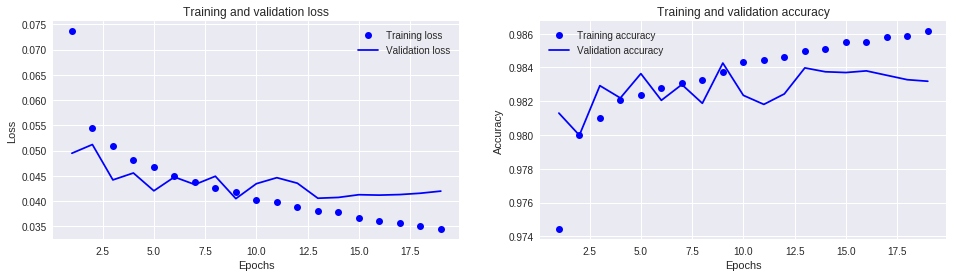

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 32s 1ms/step
([0.04055522733906229, 0.9834247072998417], 0.9898825497887489)
